In [ ]:
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/Project/NeuralOptimalTransport-main/')

# /content/drive/MyDrive/Project/NeuralOptimalTransport-main

In [ ]:
!pip install POT

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 KB 37.5 MB/s eta 0:00:00


In [ ]:
! pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 67.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.1/189.1 KB 23.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 6.8 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8807 sha256=b1a9d79650ad6e73fe92a8756404a1acec707153f86c557f10ecf34d37411a37
  Stored in directory: /root/.cache/pip/wheels/b7/0a/67/ada2a22079218c75a88361c0782855cc72aebc4d18d0289d05
Successfully built pathtools


In [ ]:
import os, sys
sys.path.append("..")

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

import numpy as np
import torch
import torch.nn as nn
import torchvision
import gc

from src import distributions
import torch.nn.functional as F

from src.resnet2 import ResNet_D
from src.unet import UNet

from src.tools import unfreeze, freeze
from src.tools import weights_init_D
from src.tools import load_dataset, get_pushed_loader_stats

# from src.tools_modified import load_dataset_modified 
from src.tools_modified_v2 import load_dataset_modified 


from src.fid_score import calculate_frechet_distance
from src.plotters import plot_random_images, plot_images

from copy import deepcopy
import json

from tqdm import tqdm_notebook as tqdm
from IPython.display import clear_output

import wandb # <--- online logging of the results
from src.tools import fig2data, fig2img # for wandb

# This needed to use dataloaders for some datasets
from PIL import PngImagePlugin
LARGE_ENOUGH_NUMBER = 100
PngImagePlugin.MAX_TEXT_CHUNK = LARGE_ENOUGH_NUMBER * (1024**2)

In [ ]:
%%javascript
//preventing GoogleColab from disconnecting:
var startClickConnect = function startClickConnect(){
  var clickConnect = function clickConnect(){
    console.log("Connect Clicked-Start");
    document.querySelector('#top-toolbar > colab-connect-button').shadowRoot.querySelector("#connect").click();
    console.log("Connect Clicked-End");
  };

  varintervalId = setInterval(clickConnect, 600000);

  var stopClickConnectHandler = function stopClickConnect(){
    console.log("Connect Clicked Stopped-Start");
    clearInterval(intervalId);
    console.log("Connect Clicked Stopped-End");
  };

  return stopClickConnectHandler;  
};

var stopClickConnect = startClickConnect();

<IPython.core.display.Javascript object>

## Main Config

In [ ]:
DEVICE_IDS = [0]

DATASET1, DATASET1_PATH = 'MNIST-colored_2', '/content/drive/MyDrive/Project/NeuralOptimalTransport-main/MNIST-colored_2_32_test_new.torch'
DATASET2, DATASET2_PATH = 'MNIST-colored_3', '/content/drive/MyDrive/Project/NeuralOptimalTransport-main/MNIST-colored_3_32_test_new.torch'


# ('handbag', '/content/drive/MyDrive/Project/NeuralOptimalTransport-main/handbag_tensor.torch', 64),
#     # ('handbag', '../../data/handbag_128.hdf5', 128),
#     ('shoes', '/content/drive/MyDrive/Project/NeuralOptimalTransport-main/shoes_tensor.torch', 64)


# DATASET1, DATASET1_PATH = 'celeba_female', '../../data/img_align_celeba'
# DATASET2, DATASET2_PATH = 'aligned_anime_faces', '../../data/aligned_anime_faces'

T_ITERS = 10
f_LR, T_LR = 1e-4, 1e-4
# IMG_SIZE = 64
IMG_SIZE = 32

BATCH_SIZE = 64

PLOT_INTERVAL = 100
COST = 'mse' # Mean Squared Error
# CPKT_INTERVAL = 2000

####################
CPKT_INTERVAL = 1500 #checkpoints interval

REGULARIZE = True    # Set to use regularizer

REG_OPT = 0          # for regularization option 
LR = [0.01, 0.001]   # learning rate for the regularization term

# REGULARIZE = False #Set to not use regularizer   

####################

MAX_STEPS = 100001
SEED = 0x000000

EXP_NAME = f'{DATASET1}_{DATASET2}_T{T_ITERS}_{COST}_{IMG_SIZE}'
OUTPUT_PATH = '../checkpoints/{}/{}_{}_{}/'.format(COST, DATASET1, DATASET2, IMG_SIZE)

## Preparation

In [ ]:
config = dict(
    DATASET1=DATASET1,
    DATASET2=DATASET2, 
    T_ITERS=T_ITERS,
    f_LR=f_LR, T_LR=T_LR,
    BATCH_SIZE=BATCH_SIZE
)
    
assert torch.cuda.is_available()
torch.cuda.set_device(f'cuda:{DEVICE_IDS[0]}')
torch.manual_seed(SEED); np.random.seed(SEED)

if not os.path.exists(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)

In [ ]:
torch.cuda.is_available()

True

## Loading data stats for testing

In [ ]:
filename = '/content/drive/MyDrive/Project/NeuralOptimalTransport-main/{}_{}_test_new.json'.format(DATASET2, IMG_SIZE)
with open(filename, 'r') as fp:
    data_stats = json.load(fp)
    mu_data, sigma_data = data_stats['mu'], data_stats['sigma']
del data_stats

## Prepare Samplers (X, Y)

In [ ]:
X_sampler, X_test_sampler = load_dataset_modified(DATASET1, DATASET1_PATH, img_size=IMG_SIZE)
Y_sampler, Y_test_sampler = load_dataset_modified(DATASET2, DATASET2_PATH, img_size=IMG_SIZE)
    
torch.cuda.empty_cache(); gc.collect()
# clear_output()

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


24

# Initializing Networks

In [ ]:
f = ResNet_D(IMG_SIZE, nc=3).cuda()
f.apply(weights_init_D)

T = UNet(3, 3, base_factor=48).cuda()

if len(DEVICE_IDS) > 1:
    T = nn.DataParallel(T, device_ids=DEVICE_IDS)
    f = nn.DataParallel(f, device_ids=DEVICE_IDS)
    
print('T params:', np.sum([np.prod(p.shape) for p in T.parameters()]))
print('f params:', np.sum([np.prod(p.shape) for p in f.parameters()]))

T params: 9715827
f params: 13494209


In [ ]:
torch.manual_seed(0xBADBEEF); np.random.seed(0xBADBEEF)
X_fixed = X_sampler.sample(10)
Y_fixed = Y_sampler.sample(10)
X_test_fixed = X_test_sampler.sample(10)
Y_test_fixed = Y_test_sampler.sample(10)

### Plots Test

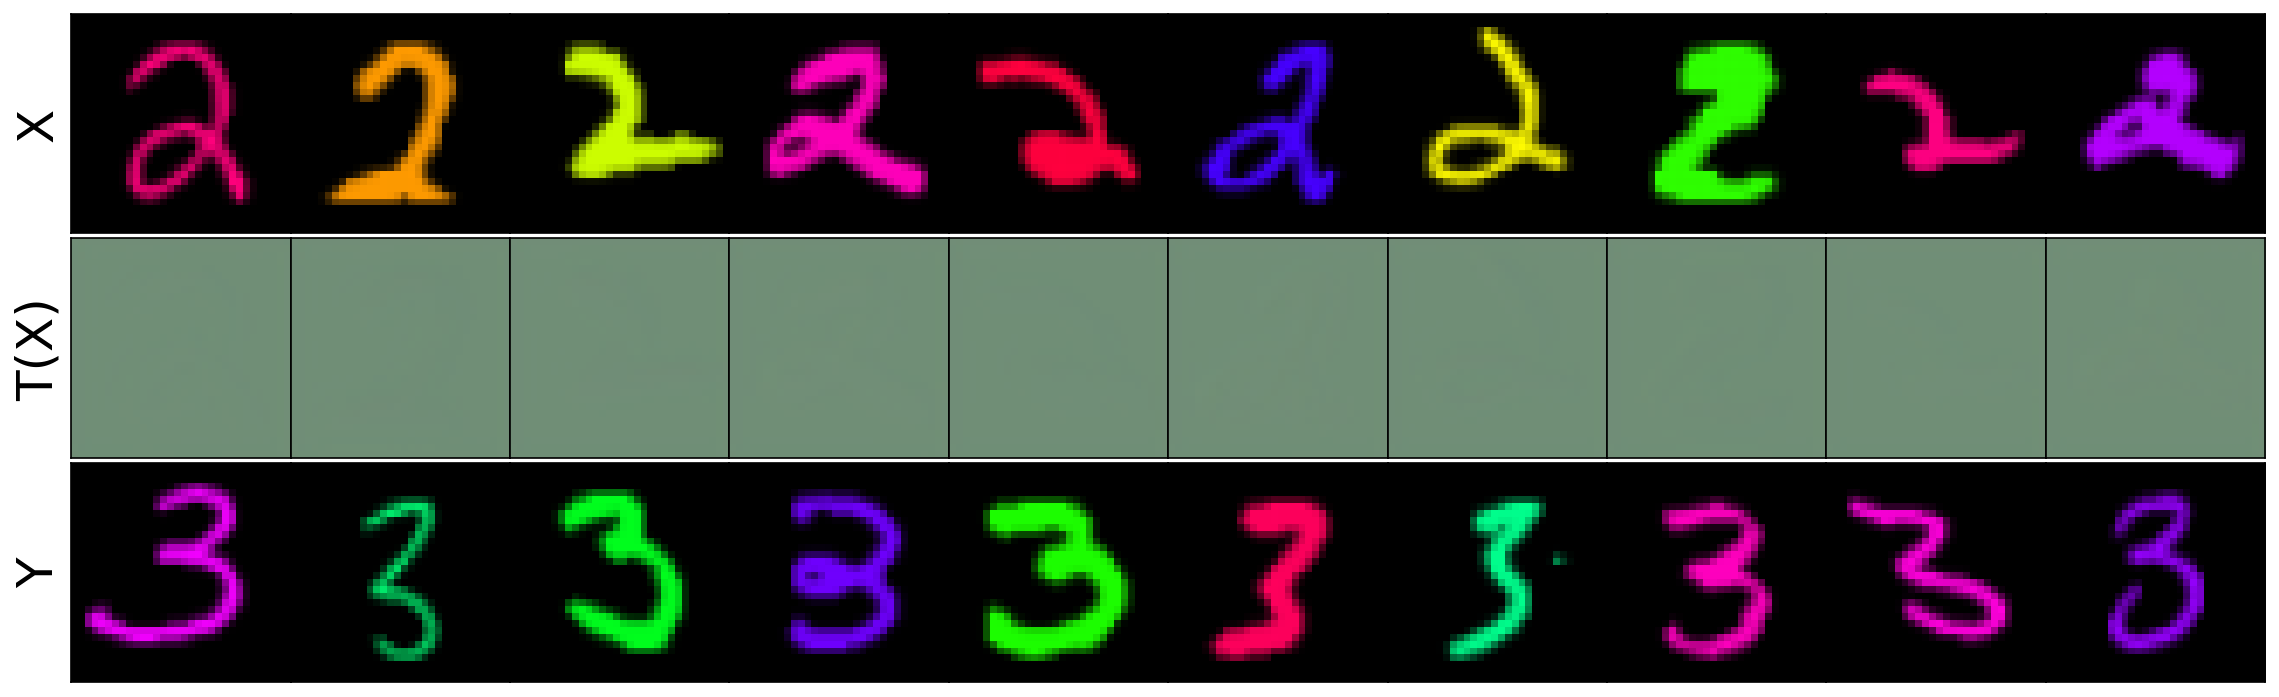

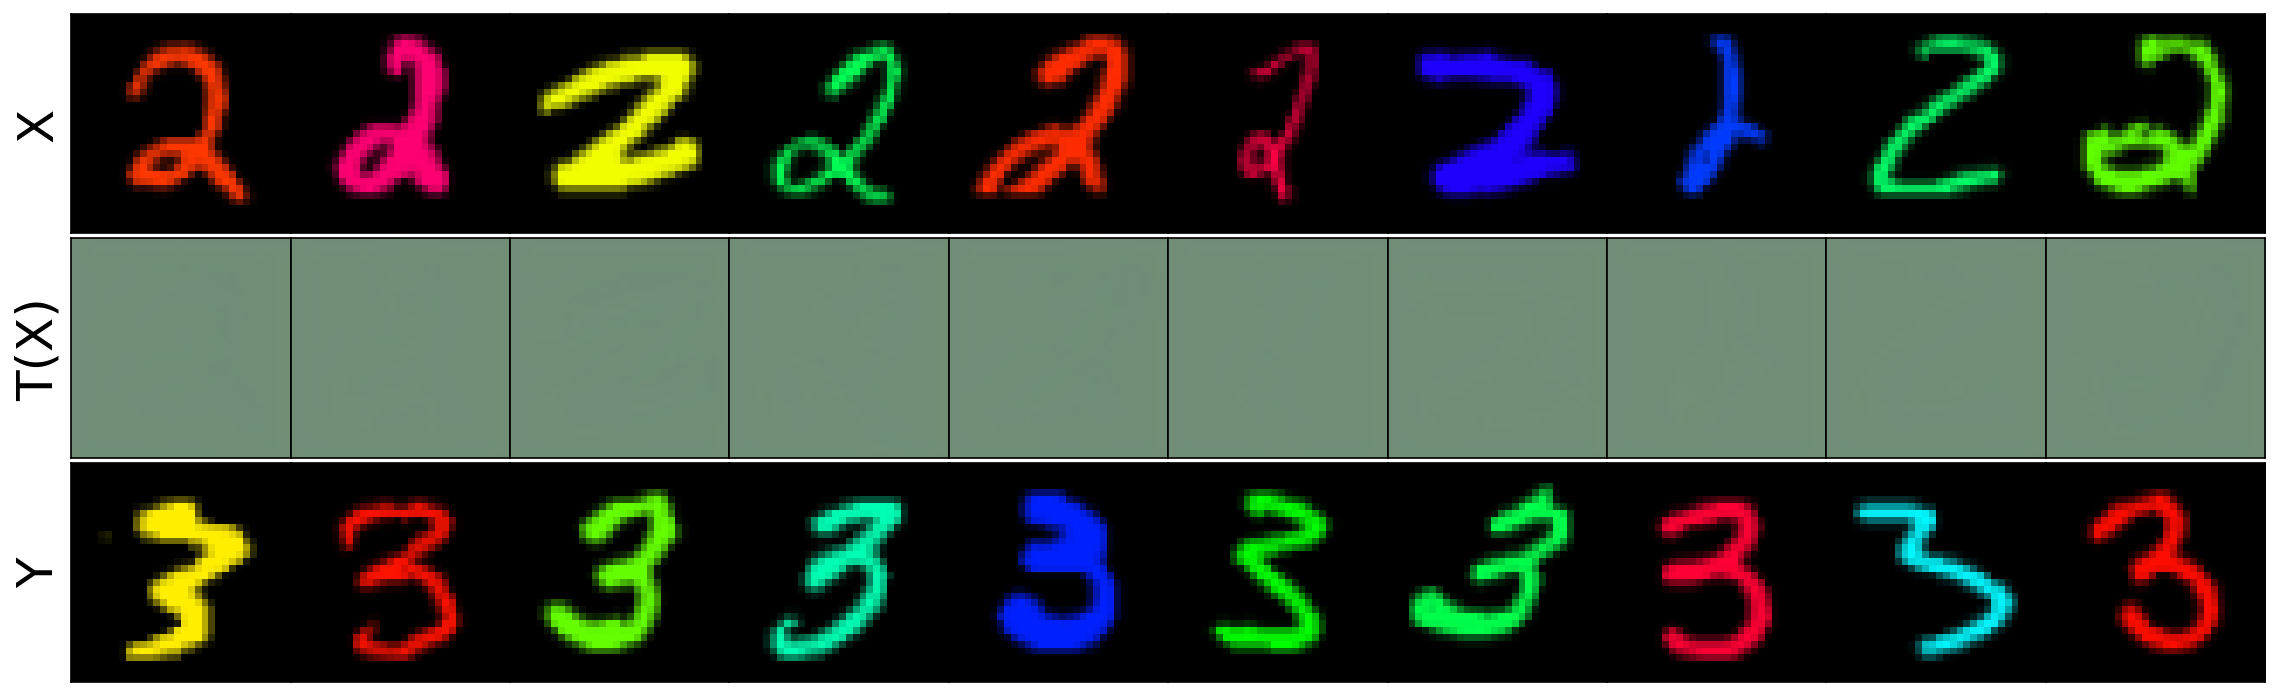

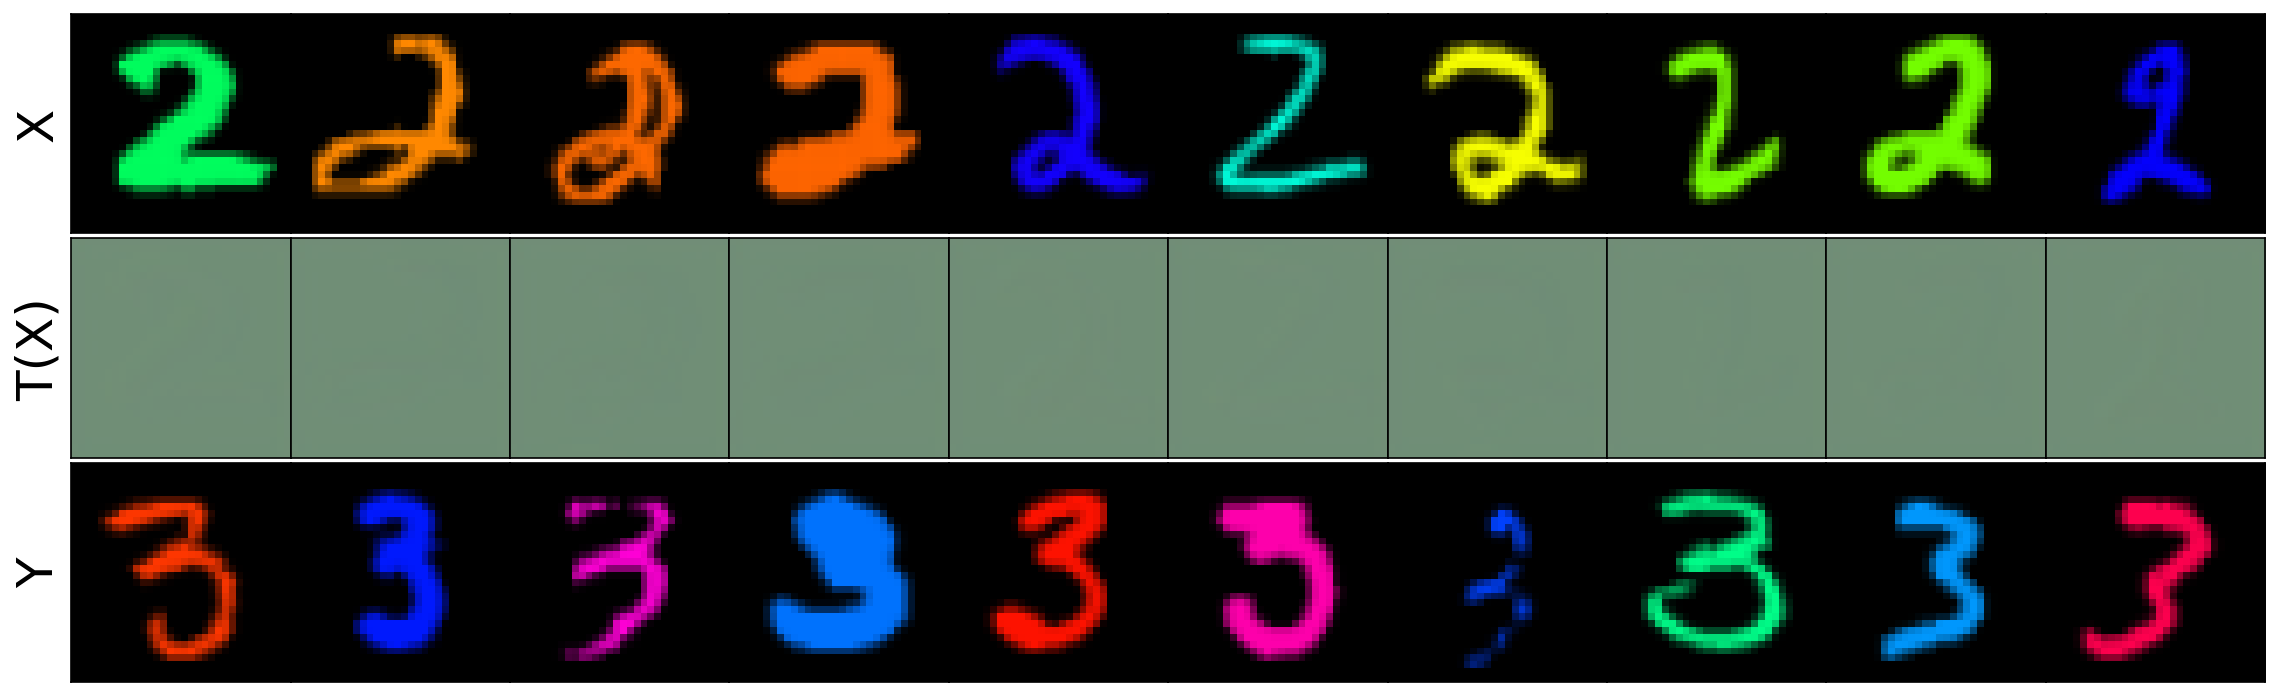

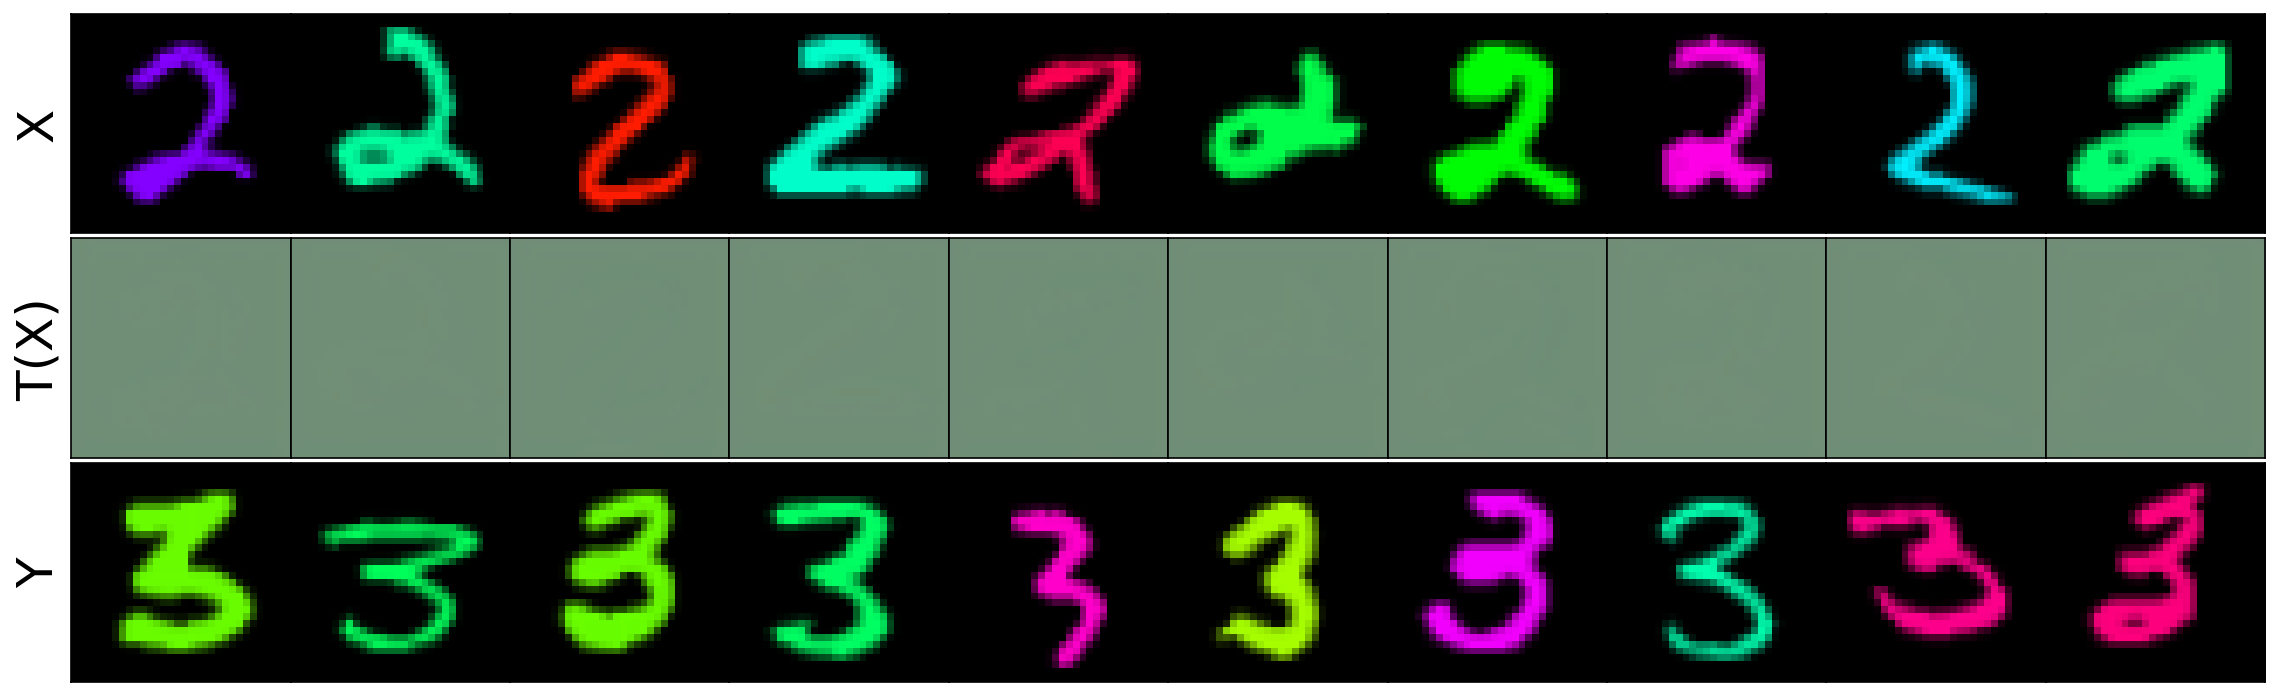

In [ ]:
fig, axes = plot_images(X_fixed, Y_fixed, T)
fig, axes = plot_random_images(X_sampler, Y_sampler, T)
fig, axes = plot_images(X_test_fixed, Y_test_fixed, T)
fig, axes = plot_random_images(X_test_sampler, Y_test_sampler, T)

In [ ]:
from pathlib import Path

# 1. Create models directory 
MODEL_PATH = Path("/content/drive/MyDrive/Project/NeuralOptimalTransport-main/models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# # 2. Create model save path 
# MODEL_NAME_1 = f'T_{SEED}_{step}.pth'
# MODEL_NAME_2 = f'f_{SEED}_{step}.pth'
# MODEL_NAME_3 = f'f_opt_{SEED}_{step}.pth'
# MODEL_NAME_4 = f'T_opt_{SEED}_{step}.pth'
# MODEL_SAVE_PATH_1 = MODEL_PATH / MODEL_NAME_1
# MODEL_SAVE_PATH_2 = MODEL_PATH / MODEL_NAME_2
# MODEL_SAVE_PATH_3 = MODEL_PATH / MODEL_NAME_3
# MODEL_SAVE_PATH_4 = MODEL_PATH / MODEL_NAME_4



# # 3. Save the model state dict 
# print(f"Saving model to: {MODEL_SAVE_PATH}")
# torch.save(obj=model_1.state_dict(), # only saving the state_dict() only saves the models learned parameters
#            f=MODEL_SAVE_PATH) 

# Run Training

In [ ]:
wandb.init(name=EXP_NAME, project='NOT_training_strong_BK', entity='bin-koff', config=config)
pass

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
T_opt = torch.optim.Adam(T.parameters(), lr=T_LR, weight_decay=1e-10)
f_opt = torch.optim.Adam(f.parameters(), lr=f_LR, weight_decay=1e-10)

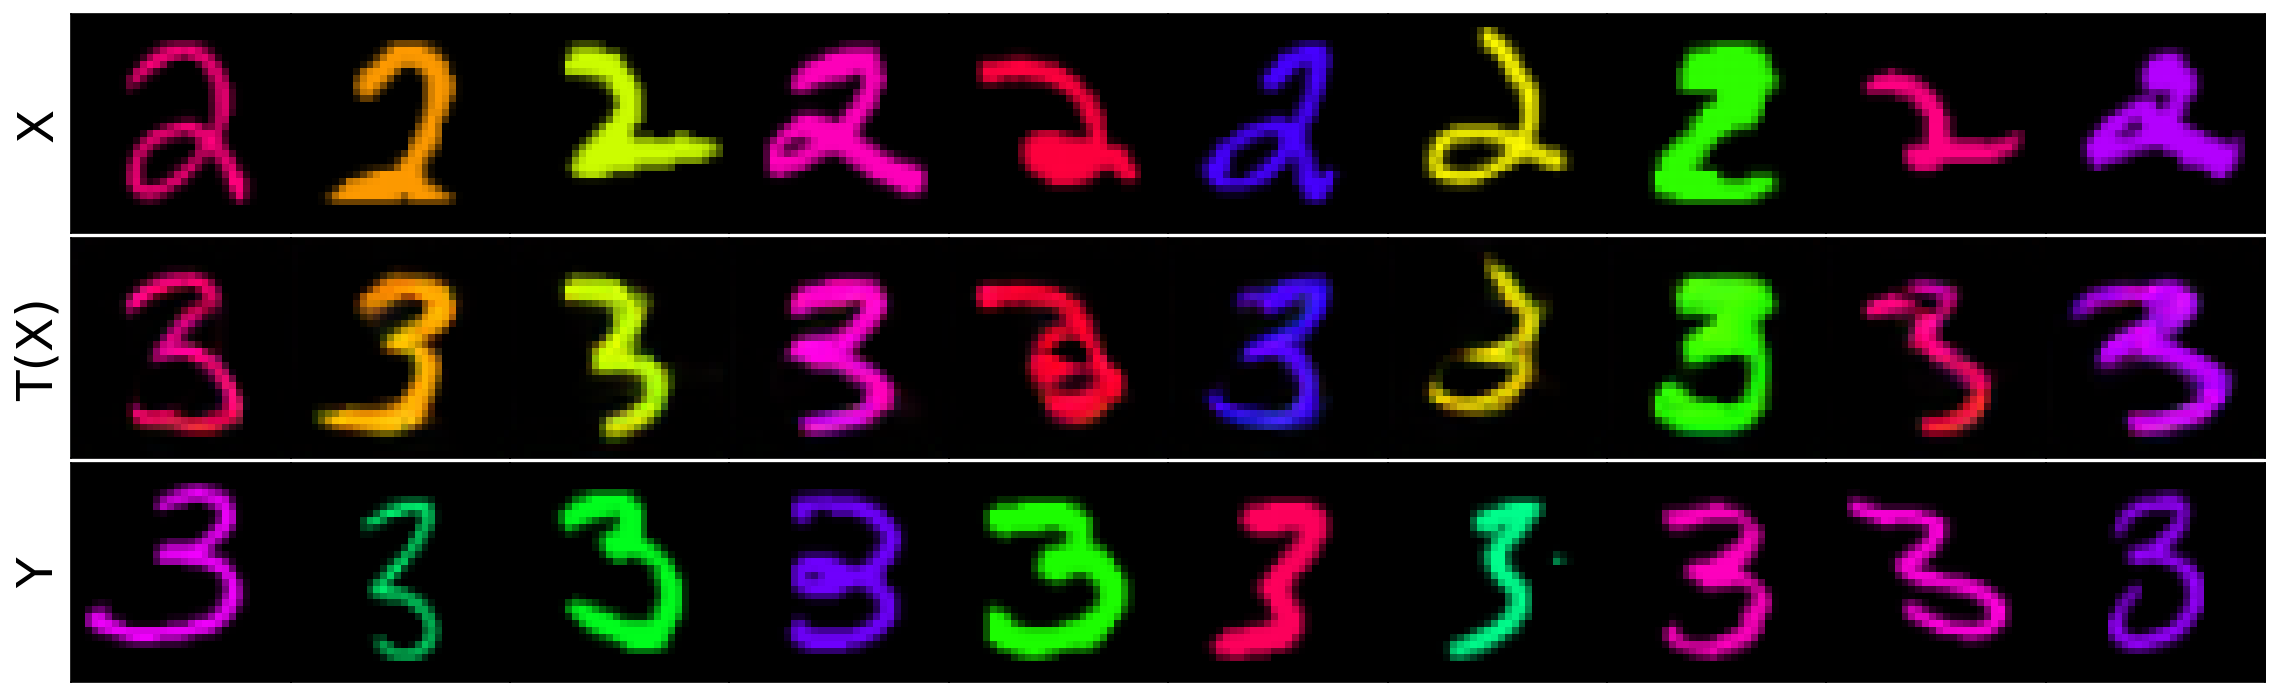

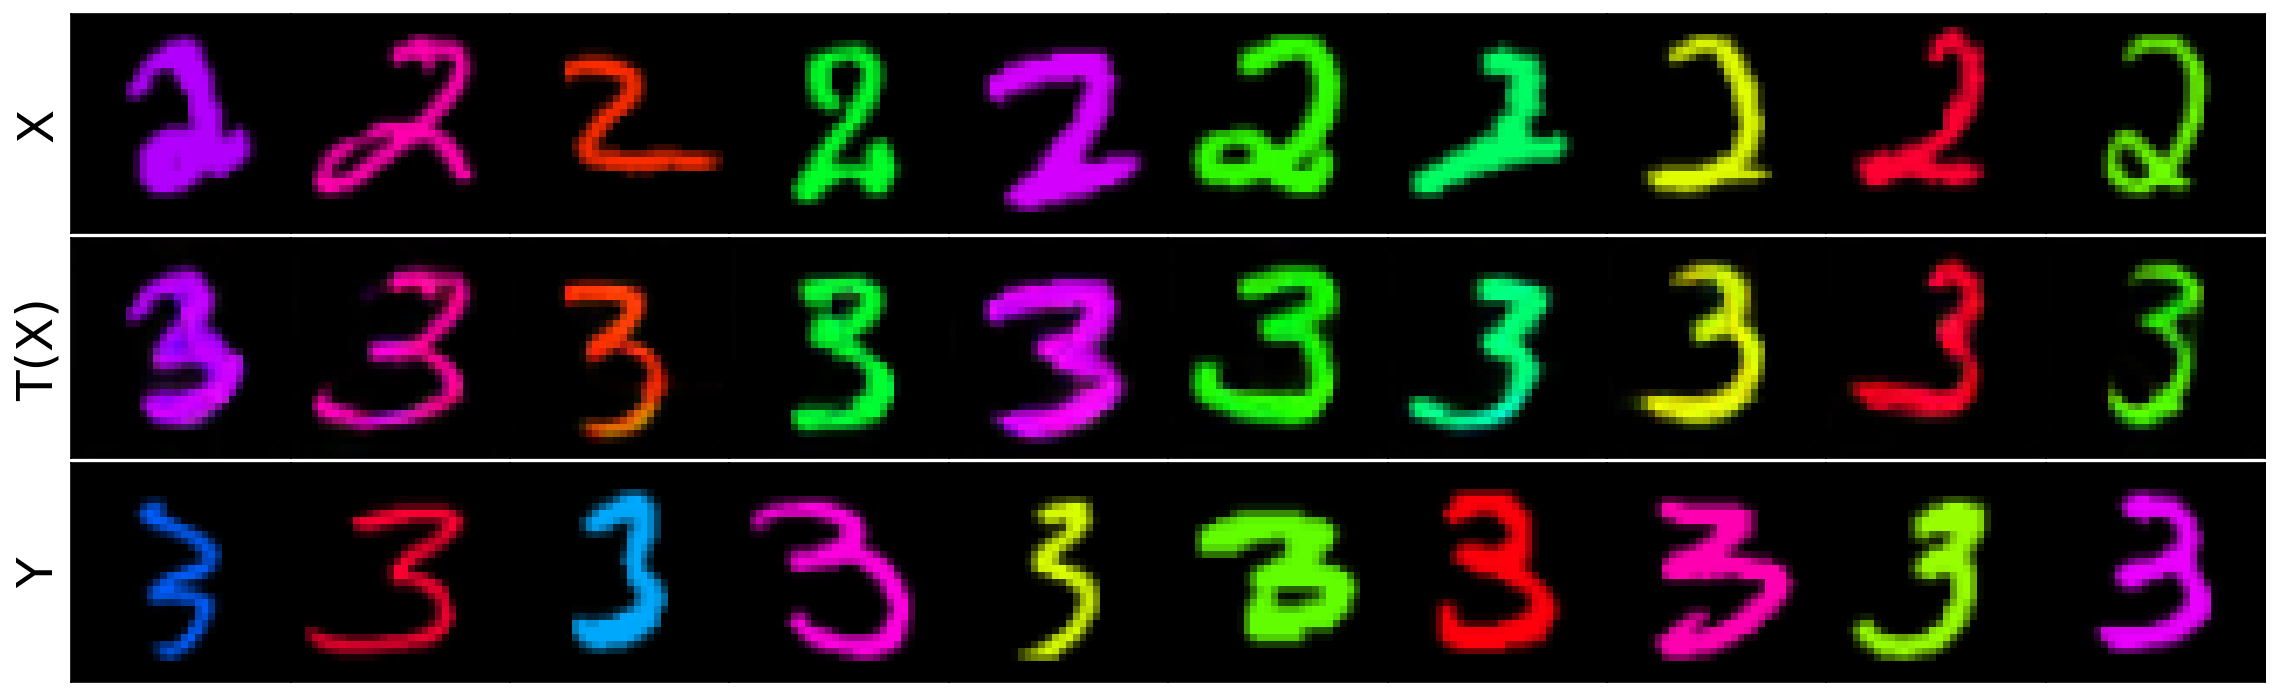

In [ ]:
for step in tqdm(range(MAX_STEPS)):
    # T optimization
    unfreeze(T); freeze(f)
    for t_iter in range(T_ITERS): 
        T_opt.zero_grad()
        X = X_sampler.sample(BATCH_SIZE)
        T_X = T(X)
        if COST == 'mse':
            T_loss = F.mse_loss(X, T_X).mean() - f(T_X).mean()
        else:
            raise Exception('Unknown COST')
        T_loss.backward(); T_opt.step()
    del T_loss, T_X, X; gc.collect(); torch.cuda.empty_cache()

    # f optimization
    freeze(T); unfreeze(f)
    X = X_sampler.sample(BATCH_SIZE)
    with torch.no_grad():
        T_X = T(X)
    Y = Y_sampler.sample(BATCH_SIZE)

    ###################### Regularization part################
    if REGULARIZE:
      # Y = Y_sampler.sample(BATCH_SIZE)
      Y_prime = Y.reshape(2,BATCH_SIZE // 2, 3, 32 ,32 ) # channel = 3, IMG_SIZE = 32x32
      Y_1, Y_2 = Y_prime[0], Y_prime[1]

      t = torch.rand(BATCH_SIZE // 2).cuda() #t in [0,1]
      # the cost function is c(x,y)= 0.5*(||x-y||^p), p=2, Wasserstein-p distance (W_p)
      psi = lambda y: -f(y)*(3*IMG_SIZE*IMG_SIZE/2) + torch.norm(y,p=2, dim = (1,2,3))**2 /2
      L = psi(t *Y_1 +(1 - t)*Y_2 ) - t* psi(Y_1) + (1-t)*psi(Y_2)
            
      if REG_OPT==0:
        R,lr = nn.functional.relu(L), LR[0]
      else:
        R,lr = nn.functional.relu(L), LR[1]

      f_opt.zero_grad()
      '''
      f_loss is mathematically defined as the difference between f(T_x) - f(Y) on target domain
      plus the the multiplication between learning_rate and the average of R.
      '''
      f_loss = f(T_X).mean() - f(Y).mean() + lr*R.mean() 
      f_loss.backward(); f_opt.step();
      wandb.log({f'f_loss' : f_loss.item()}, step=step)
      wandb.log({f'L' : L.mean().item()}, step=step) 
      wandb.log({f'L_max' : L.max().item()}, step=step) 
      del f_loss, Y, X, T_X; gc.collect(); torch.cuda.empty_cache()
      
    ###################### End of Regularization part###############

    else: #without regularization
      f_opt.zero_grad()
      f_loss = f(T_X).mean() - f(Y).mean()
      f_loss.backward(); f_opt.step();
      wandb.log({f'f_loss' : f_loss.item()}, step=step) 
      del f_loss, Y, X, T_X; gc.collect(); torch.cuda.empty_cache()
          
    if step % PLOT_INTERVAL == 0:
        print('Plotting')
        clear_output(wait=True)
        
        fig, axes = plot_images(X_fixed, Y_fixed, T)
        wandb.log({'Fixed Images' : [wandb.Image(fig2img(fig))]}, step=step) 
        plt.show(fig); plt.close(fig) 
        
        fig, axes = plot_random_images(X_sampler,  Y_sampler, T)
        wandb.log({'Random Images' : [wandb.Image(fig2img(fig))]}, step=step) 
        plt.show(fig); plt.close(fig) 
        
        fig, axes = plot_images(X_test_fixed, Y_test_fixed, T)
        wandb.log({'Fixed Test Images' : [wandb.Image(fig2img(fig))]}, step=step) 
        plt.show(fig); plt.close(fig) 
        
        fig, axes = plot_random_images(X_test_sampler, Y_test_sampler, T)
        wandb.log({'Random Test Images' : [wandb.Image(fig2img(fig))]}, step=step) 
        plt.show(fig); plt.close(fig) 
    
    if step % CPKT_INTERVAL == CPKT_INTERVAL - 1:
        freeze(T); 
        
        print('Computing FID')
        mu, sigma = get_pushed_loader_stats(T, X_test_sampler.loader)
        fid = calculate_frechet_distance(mu_data, sigma_data, mu, sigma)
        wandb.log({f'FID (Test)' : fid}, step=step)
        del mu, sigma


        # 2. Create model save path 
        MODEL_NAME_1 = f'T_{SEED}_{step}.pth'
        MODEL_NAME_2 = f'f_{SEED}_{step}.pth'
        MODEL_NAME_3 = f'f_opt_{SEED}_{step}.pth'
        MODEL_NAME_4 = f'T_opt_{SEED}_{step}.pth'
        MODEL_SAVE_PATH_1 = MODEL_PATH / MODEL_NAME_1
        MODEL_SAVE_PATH_2 = MODEL_PATH / MODEL_NAME_2
        MODEL_SAVE_PATH_3 = MODEL_PATH / MODEL_NAME_3
        MODEL_SAVE_PATH_4 = MODEL_PATH / MODEL_NAME_4
        
        
        torch.save(T.state_dict(),f= MODEL_SAVE_PATH_1)
        torch.save(f.state_dict(), f=MODEL_SAVE_PATH_2)
        torch.save(f_opt.state_dict(),f=MODEL_SAVE_PATH_3)
        torch.save(T_opt.state_dict(), f=MODEL_SAVE_PATH_4)
        # print(step)

        # Models with regularizer
    
    gc.collect(); torch.cuda.empty_cache()